In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import neighbors

import statsmodels.formula.api as smf

import seaborn as sns


In [9]:
#Load data and specific set of columns of interest
df = pd.read_csv('nyc-rolling-sales.csv')
df_sales = df.loc[(df['SALE PRICE'].replace(' -  ','0').astype(float) > 0.00),['BOROUGH','NEIGHBORHOOD','RESIDENTIAL UNITS','COMMERCIAL UNITS','GROSS SQUARE FEET','LAND SQUARE FEET','SALE PRICE']]


In [15]:

#SALE PRICE, LAND AND GROSS SQUARE FEET, AND RESIDENTIAL UNITS ARE object but should be numeric
df_sales['SALE PRICE'] = pd.to_numeric(df_sales['SALE PRICE'], errors='coerce')
df_sales['LAND SQUARE FEET'] = pd.to_numeric(df_sales['LAND SQUARE FEET'], errors='coerce')
df_sales['GROSS SQUARE FEET']= pd.to_numeric(df_sales['GROSS SQUARE FEET'], errors='coerce')
df_sales['RESIDENTIAL UNITS']= pd.to_numeric(df_sales['RESIDENTIAL UNITS'], errors='coerce')
df_sales['log_sale_price']=np.log(df_sales['SALE PRICE'])
df_sales['GSF_PER_RU']=df_sales['GROSS SQUARE FEET']/df_sales['RESIDENTIAL UNITS']

#Update Boroughs
df_sales['BOROUGH'][df_sales['BOROUGH'] == 1] = 'Manhattan'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 2] = 'Bronx'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 3] = 'Brooklyn'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 4] = 'Queens'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 5] = 'Staten Island'

   
#Remove outliers
df_sales_nonoutliers = df_sales[(df_sales['SALE PRICE'] > 100000) & (df_sales['SALE PRICE'] < 5000000) & (df_sales['RESIDENTIAL UNITS'] > 0) & (df_sales['GROSS SQUARE FEET'] > 0) & (df_sales['GROSS SQUARE FEET'] < 10000)]

#drop gross square feet and residential units now that GSF_PER-RU is created
df_sales_nonoutliers.drop(columns=['GROSS SQUARE FEET'], axis=1, inplace=True)
 
#Add Dummies
df_sales_nonoutliers = pd.get_dummies(df_sales_nonoutliers)

#Drop non-numeric rows
df_sales_nonoutliers = df_sales_nonoutliers.select_dtypes(include=[np.number]).dropna()


C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [16]:
df_sales_nonoutliers.head()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,SALE PRICE,log_sale_price,GSF_PER_RU,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,...,NEIGHBORHOOD_WILLIAMSBURG-EAST,NEIGHBORHOOD_WILLIAMSBURG-NORTH,NEIGHBORHOOD_WILLIAMSBURG-SOUTH,NEIGHBORHOOD_WILLOWBROOK,NEIGHBORHOOD_WINDSOR TERRACE,NEIGHBORHOOD_WOODHAVEN,NEIGHBORHOOD_WOODLAWN,NEIGHBORHOOD_WOODROW,NEIGHBORHOOD_WOODSIDE,NEIGHBORHOOD_WYCKOFF HEIGHTS
3,10,0,2272.0,3936272,15.185745,679.400000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,8,0,1750.0,3192840,14.976421,528.250000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
172,3,1,1520.0,3300000,15.009433,1120.000000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
174,5,1,1779.0,4750000,15.373655,742.600000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
222,9,0,1566.0,1583840,14.275363,703.333333,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Split into training and test set

#Set y-variable
y_output_log_sale = df_sales_nonoutliers['log_sale_price']
y_output_sale = df_sales_nonoutliers['SALE PRICE']

#Create x-variables set
df_sales_nonoutliers.drop(columns=['log_sale_price','SALE PRICE'], axis=1, inplace=True)


#Split the data
#train_inp, test_inp, train_out, test_out =  train_test_split(df_sales_nonoutliers, y_output_log_sale, test_size=0.2)
train_inp, test_inp, train_out, test_out =  train_test_split(df_sales_nonoutliers, y_output_sale, test_size=0.2)


In [20]:
#dataframe transformer
def transform_sales(X):
    
    X = pd.DataFrame(X, columns=train_inp.columns)   
    X['Is_Big_Building'] = np.where(X['RESIDENTIAL UNITS'] >= 3, 1, 0)
    X['hasBusiness'] = np.where(X['COMMERCIAL UNITS'] >= 1, 1, 0)
    X['Log_LSF'] = np.log(X['LAND SQUARE FEET'])    
    X.drop(columns=['COMMERCIAL UNITS','LAND SQUARE FEET'], axis=1, inplace=True)
    return X.as_matrix()


In [657]:
#transform, scale, pca, regressor

transformer = FunctionTransformer(transform_sales)
scaler =  StandardScaler()

tests = []
regressor_names = ['Linear Regression',  'KNN']

#For each type of regression (linear and KNN)
for i in range(0,2):
     
    if regressor_names[i] == 'KNN':       
        #for each num neighbors
        for nn in range(40,60):
            regressor = neighbors.KNeighborsRegressor(n_neighbors=nn, weights='distance')
                 #for each pca level
            for n in range(1,7):
                sklearn_pca = PCA(n_components=n)

                pipe = Pipeline([
                    ('transform', transformer),
                    ('scale', scaler),
                    ('pca', sklearn_pca),
                    ('regress', regressor)
                ])

                pipe.fit(train_inp, train_out)
                tests.append(('scale+pca',regressor_names[i],n,nn, r2_score(test_out,pipe.predict(test_inp))))

                pipe = Pipeline([
                    ('transform', transformer),
                    ('pca', sklearn_pca),
                    ('regress', regressor)
                ])

                pipe.fit(train_inp, train_out)
                tests.append(('pca, no scale',regressor_names[i],n,nn, r2_score(test_out,pipe.predict(test_inp))))

                pipe = Pipeline([
                    ('transform', transformer),
                    ('regress', regressor)
                ])

                pipe.fit(train_inp, train_out)
                tests.append(('no pca, no scale',regressor_names[i],n,nn, r2_score(test_out,pipe.predict(test_inp))))
   
    
    else:
        regressor = LinearRegression()


        #for each pca level
        for n in range(1,7):
            sklearn_pca = PCA(n_components=n)

            pipe = Pipeline([
                ('transform', transformer),
                ('scale', scaler),
                ('pca', sklearn_pca),
                ('regress', regressor)
            ])

            pipe.fit(train_inp, train_out)
            tests.append(('scale+pca',regressor_names[i],n,'N/A', r2_score(test_out,pipe.predict(test_inp))))

            pipe = Pipeline([
                ('transform', transformer),
                ('pca', sklearn_pca),
                ('regress', regressor)
            ])

            pipe.fit(train_inp, train_out)
            tests.append(('pca, no scale',regressor_names[i],n,'N/A', r2_score(test_out,pipe.predict(test_inp))))

            pipe = Pipeline([
                ('transform', transformer),
                ('regress', regressor)
            ])

            pipe.fit(train_inp, train_out)
            tests.append(('no pca, no scale',regressor_names[i],n,'N/A', r2_score(test_out,pipe.predict(test_inp))))

In [658]:
y = pd.DataFrame(tests)
y.columns = ['scenario', 'reg_type','pca_components','knn_num_neighbors','r-squared']
#y.to_csv('ols_knn.csv')

y.sort_values('r-squared',ascending=False).head()


,scenario,reg_type,pca_components,knn_num_neighbors,r-squared
357,scale+pca,KNN,6,58,0.368722
339,scale+pca,KNN,6,57,0.368616
375,scale+pca,KNN,6,59,0.368551
285,scale+pca,KNN,6,54,0.368476
321,scale+pca,KNN,6,56,0.368356


In [21]:

transformer = FunctionTransformer(transform_sales)
scaler =  StandardScaler()
regressor = neighbors.KNeighborsRegressor(n_neighbors=49, weights='distance')
sklearn_pca = PCA(n_components=6)

pipe = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('pca', sklearn_pca),
    ('regress', regressor)
])

pipe.fit(train_inp, train_out)
print(r2_score(test_out,pipe.predict(test_inp)))

0.5177381572383999


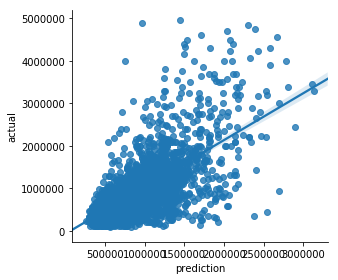

In [22]:
#plt.scatter(pipe.predict(test_inp),test_out)
test = pd.DataFrame(np.column_stack((pipe.predict(test_inp),test_out)))

test.columns = ['prediction','actual']
g = sns.lmplot(x='prediction', y='actual'
               ,fit_reg=True
               ,data=test, size=4, aspect=1.2)
plt.show()



In [25]:


from sklearn import ensemble
from sklearn.model_selection import cross_val_score




transformer = FunctionTransformer(transform_sales)
scaler =  StandardScaler()
classifier = ensemble.RandomForestClassifier()
sklearn_pca = PCA(n_components=6)

pipe = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    #('pca', sklearn_pca),
    ('classify', classifier)
])

cross_val_score(pipe, test_inp, test_out, cv=10)

#pipe.fit(train_inp, train_out)
#print(r2_score(test_out,pipe.predict(test_inp)))

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.01048735, 0.01690141, 0.01328273, 0.01354402, 0.00771208,
       0.01699717, 0.01234568, 0.01041667, 0.00374532, 0.02074689])

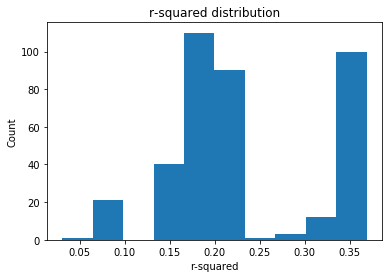

In [661]:

# Plot property crime
plt.hist(y['r-squared'])
plt.title('r-squared distribution')
plt.xlabel('r-squared')
plt.ylabel('Count')
plt.show()



After testing both the OLS and KNN model to predict real estate sales in NYC, the KNN model is superior in terms of R-squared, although the best linear regression and KNN model differ by approximately 3% in terms of r-squared.

Overall, this indicates that the majority of variance is not explained in the variables chosen, and it would make sense to add features for neighborhood, amenities indicators, school district information, outdoor space, views, parking, etc.

Question to David:  Aside from scoring, what other factors would motivate choosing one over the other?  Presumably the explanatory power of a linear regression and the ability to assign a number for each feature to explain how much they impact sales is useful, but beyond that, because the model isn't great to begin with, I'd choose the highest R-squared. 

The remainder of the notebook is just checks

In [6]:
#dataframe transformer
def transform_sales_df(Y):
    X =  Y    
    X = pd.DataFrame(X, columns=train_inp.columns)    
    X['In_City'] = np.where(X['BOROUGH'] == 1, 1, 0)
    X['Is_Big_Building'] = np.where(X['RESIDENTIAL UNITS'] >= 3, 1, 0)
    X['hasBusiness'] = np.where(X['COMMERCIAL UNITS'] >= 1, 1, 0)
    X['Log_LSF'] = np.log(X['LAND SQUARE FEET'])
    X.drop(columns=['BOROUGH', 'COMMERCIAL UNITS','LAND SQUARE FEET'], axis=1, inplace=True)
    return X

In [28]:
#transform, scale, pca, regressor - KNN

transformer = FunctionTransformer(transform_sales)
scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
sklearn_pca = PCA(n_components=4)
regressor = neighbors.KNeighborsRegressor(n_neighbors=25, weights='distance')

pipe = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('pca', sklearn_pca),
    #('regress', regressor)
])

#for debugging
#x =pipe.fit_transform(train_inp)


pipe.fit(train_inp, train_out)
print('knn')
print(r2_score(test_out,pipe.predict(test_inp)))

In [27]:
train_inp

,BOROUGH,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GSF_PER_RU,In_City,Is_Big_Building,hasBusiness,Log_LSF
19130,2,1,0,4777.0,997.00,0,0,0,8.471568
59489,4,2,0,1800.0,891.00,0,0,0,7.495542
32655,3,2,0,2382.0,912.00,0,0,0,7.775696
36976,3,4,2,2500.0,799.50,0,1,1,7.824046
55645,4,2,0,2450.0,262.50,0,0,0,7.803843
73261,4,2,0,3500.0,791.00,0,0,0,8.160518
44166,3,1,0,2000.0,1248.00,0,0,0,7.600902
61132,4,1,0,4000.0,1491.00,0,0,0,8.294050
20355,2,2,0,2500.0,1340.00,0,0,0,7.824046
26600,3,2,0,1700.0,1200.00,0,0,0,7.438384


In [26]:
x =pipe.fit_transform(train_inp, train_out)
pd.DataFrame(x)

,0,1,2,3
0,-0.797169,-0.248973,0.822192,0.074652
1,0.306494,-0.843878,-0.694376,-0.002179
2,0.139497,-0.646939,-0.204877,0.002485
3,3.242605,3.236339,-1.219739,-2.706553
4,0.570426,-1.282969,-0.233320,-0.106431
5,0.013064,-0.527235,0.449653,-0.016264
6,-0.495473,-0.542715,-0.661402,0.113249
7,-1.039912,0.136819,0.572456,0.156858
8,-0.180904,-0.185835,-0.069843,0.074529
9,0.125314,-0.568751,-0.756926,0.049460


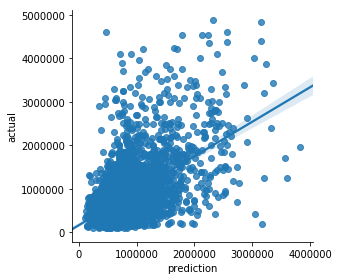

In [8]:
#plt.scatter(pipe.predict(test_inp),test_out)
test = pd.DataFrame(np.column_stack((pipe.predict(test_inp),test_out)))

test.columns = ['prediction','actual']
g = sns.lmplot(x='prediction', y='actual'
               ,fit_reg=True
               ,data=test, size=4, aspect=1.2)
plt.show()



In [9]:
train_inp_copy = pd.DataFrame()
train_out_copy = pd.DataFrame()
test_inp_copy = pd.DataFrame()
test_out_copy = pd.DataFrame()

train_inp_copy = train_inp
train_out_copy = train_out

test_inp_copy = test_inp
test_out_copy = test_out



x=transform_sales_df(train_inp_copy)
y=pd.concat((x,train_out_copy), axis=1)
y.columns = ['ru', 'gfs_per_ru', 'in_city','big_building','hasBusiness','log_lsf','sale_price']

xx=transform_sales_df(test_inp_copy)
yy=pd.concat((xx,test_out_copy), axis=1)
yy.columns = ['ru', 'gfs_per_ru', 'in_city','big_building','hasBusiness','log_lsf','sale_price']

y.columns
#scaling
#y[y.columns] = scaler.fit_transform(y[y.columns])


Index(['ru', 'gfs_per_ru', 'in_city', 'big_building', 'hasBusiness', 'log_lsf',
       'sale_price'],
      dtype='object')

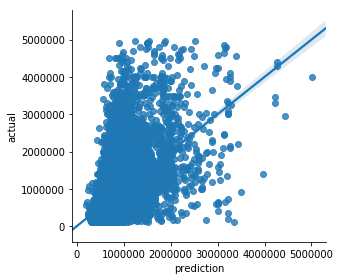

In [12]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

linear_formula = 'sale_price ~ ru+gfs_per_ru+in_city+big_building+hasBusiness+log_lsf'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=y).fit()

test2 = pd.DataFrame(np.column_stack((lm.predict(y),train_out)))
test2.columns = ['prediction','actual']
g = sns.lmplot(x='prediction', y='actual'
               ,fit_reg=True
               ,data=test2, size=4, aspect=1.2)
plt.show()

In [13]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     1452.
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        21:14:46   Log-Likelihood:            -2.9953e+05
No. Observations:               20650   AIC:                         5.991e+05
Df Residuals:                   20643   BIC:                         5.991e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.052e+05   5.96e+04      3.441      0.001    8.83e+04    3.22e+05
ru            1.896e+05   4276.093     44.332      0.000    1.81e+05    1.98e+05
gfs_per_ru     345.7114      6.694     51.643      0.000     332.590     358.833
in_city       9.777e+05   3.71e+04     26.342      0.000    9.05e+05    1.05e+06
big_building  1.116e+05    1.4e+04      7.964      0.000    8.41e+04    1.39e+05
hasBusiness   1.819e+05   1.74e+04     10.473      0.000    1.48e+05    2.16e+05
log_lsf      -3.227e+04   7798.649     -4.137      0.000   -4.76e+04    -1.7e+04
==============================================================================
Omnibus:                    10488.959   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121635.808
Skew:                           2.175   Prob(JB):                         0.00
Kurtosis:                      14.066   Cond. No.                     2.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
#regressor.coef_

#regressor.get_params
print(list(zip(regressor.coef_, yy.columns)))


AttributeError: 'KNeighborsRegressor' object has no attribute 'coef_'

Sale Price vs. Log Sale Price
OLS vs. KNN
KNN 1 - 50
PCA 0 -6
Scaler vs. No Scaler



In [616]:
print(str.replace('lou','u','is'))

lois
